# Region level

### Filtering, renaming, and aggregating

In [5]:
#hide_input
from mo_covid19.data import *
import plotly.io as pio
pio.renderers.default='notebook'

In [6]:
#hide_input
locations_type = "region"
data = collect_data(type_=locations_type)

data.loc[data.locality_name == 'State of São Paulo', 'locality_name'] = "São Paulo"
data.loc[data.locality_name == 'State of Amazonas', 'locality_name'] = "Amazonas"
data.loc[data.locality_name == 'Lombardy', 'locality_name'] = "Lombardia"

long_regions = data.melt(id_vars=["locality_name", "date"], var_name="category", value_name="value")

In [7]:
#hide_input
regions = ["Île-de-France", "Amazonas", "São Paulo", "Lombardia", "New York"]

colors_sequence_category = [
    "#AB63FA",
    "#19D3F3",
    "#FF6692",
    "#68BEBA",
    "#FF7F0E",
    "#8C564B",
]
colors_sequence_locality = colors_sequence_category + ["#DAA51F"]

colors_map_locality = dict(zip(regions, colors_sequence_locality))

#### Inspecting regions

In [9]:
fig = px.line(long_regions, x="date", y="value", color="category", labels=plotly_labels, color_discrete_sequence = colors_sequence_category,
              facet_col="locality_name", facet_col_wrap=2, height=800)
fig.show()

## Data preparation

### Enriching with dates

In [7]:
#hide_input
data_lockdown = { 
    "first_case_date": {
        "Argentina": "2020-03-04",
        "Japan": "2020-01-15",
        "South Korea": "2020-01-20",
        "Canada": "2020-01-26",
        "Germany": "2020-01-28",
        "Spain": "2020-02-01",
        "Argentina": "2020-03-04",
        "New Zealand": "2020-02-28",

        "São Paulo": "2020-02-26", 
        "Amazonas": "2020-03-13",  
        "Île-de-France": "2020-01-23", 
        "Lombardia": "2020-02-14",  
        "New York": "2020-03-01",
    },
    "restriction_date": {
        "Argentina": "2020-03-16",
        "Japan": "2020-03-02",  
        "South Korea": "2020-02-22",
        "Canada": "2020-03-16",  
        "Germany":"2020-03-16",  
        "Spain":"2020-03-09",
        "Argentina":"2020-03-16",
        "New Zealand":"2020-03-24", 

        "São Paulo": "2020-03-16", 
        "Amazonas": "2020-03-16",  
        "Île-de-France": "2020-03-12",
        "Lombardia": "2020-02-23",  
        "New York": "2020-03-15",

    },
    "ease_restriction_date": {
        "Argentina": "2020-05-15",
        "Japan": "2020-05-15",  
        "South Korea": "2020-05-15",
        "Canada": "2020-05-15",  
        "Germany": "2020-05-15",  
        "Spain": "2020-05-15",
        "Argentina": "2020-05-15",
        "New Zealand": "2020-05-15",

        "São Paulo": "2020-06-01", 
        "Amazonas": "2020-05-31",  
        "Île-de-France": "2020-05-11", 
        "Lombardia": "2020-05-04",  
        "New York": "2020-05-15",
    }
}

data_period = add_days_columns(data, data_lockdown)
data_period.head()

,date,locality_name,retail,grocery_pharmacy,parks,transit_stations,workplaces,residential,first_case_date,restriction_date,ease_restriction_date,n_days_since_first_case,n_days_since_restriction,n_days_since_ease_restriction
0,2020-02-15,Lombardia,3.076923,-3.538462,42.307692,9.615385,-1.076923,-0.846154,2020-02-14,2020-02-23,2020-05-04,1,-8,-79
1,2020-02-15,New York,9.096774,-0.967742,16.892857,10.625000,0.387097,-0.179487,2020-03-01,2020-03-15,2020-05-15,-15,-29,-90
2,2020-02-15,Amazonas,-2.857143,5.750000,-19.500000,-5.333333,6.500000,-1.000000,2020-03-13,2020-03-16,2020-05-31,-27,-30,-106
3,2020-02-15,São Paulo,2.424528,1.944724,2.500000,1.007576,6.419355,-0.676647,2020-02-26,2020-03-16,2020-06-01,-11,-30,-107
4,2020-02-15,Île-de-France,-11.555556,-10.444444,7.333333,3.222222,-8.222222,-1.222222,2020-01-23,2020-03-12,2020-05-11,23,-26,-86


(-120.0, 220.0)

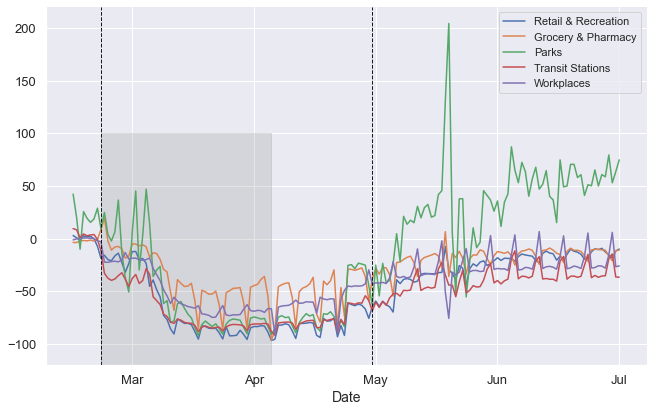

In [8]:
#hide_input
import matplotlib.dates as mdates

id_vars = ["date", "locality_name", "first_case_date", "restriction_date", "ease_restriction_date", "n_days_since_first_case", "n_days_since_restriction", "n_days_since_ease_restriction",]
data_to_plot = data_period.melt(
    id_vars,
    var_name="category", 
    value_name="value"
).query('locality_name=="Lombardia" and category!="residential" and date <= "2020-07-21"')

long_regions_plot = sns.relplot(
    x="date", 
    y="value", 
    hue="category", 
    data = data_to_plot, 
    col="locality_name", 
    col_wrap=2, 
    kind="line", 
    height=6, 
    legend="brief", 
    aspect=1.5, 
    markers=True, 
    dashes=True
)

        
long_regions_plot._legend.remove()

# Iterate thorugh each axis
for ax in long_regions_plot.axes:
    ax.set(xlabel='Date', ylabel='') 

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        set_labels = ['Retail & Recreation', 'Grocery & Pharmacy', 'Parks', 'Transit Stations', 'Workplaces'] #labels[1:]
        ax.legend(handles=handles[1:], labels=set_labels, title="", fontsize=11, title_fontsize=11)


    # Make x and y-axis labels slightly larger
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)

    # Make title more human-readable and larger
    if ax.get_title():
        ax.set_title("")

    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))

    # Make right ylabel more human-readable and larger 
    if ax.texts:
        # This contains the right ylabel text
        txt = ax.texts[0]
        ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
              txt.get_text().split('=')[1],
              transform=ax.transAxes,
              va='center',
              fontsize='xx-large')
        # Remove the original text
        ax.texts[0].remove()

    ax.fill_between(data_to_plot.query("50 > n_days_since_restriction >= 0")["date"], -150, 100, color="gray", alpha=0.2)

from datetime import datetime

restriction_date = datetime.strptime('2020-02-23', '%Y-%m-%d') 
ease_restriction_date = datetime.strptime("2020-05-11", '%Y-%m-%d')

plt.axvline(restriction_date, color='k', linestyle='dashed', linewidth=1)
plt.axvline(ease_restriction_date, color='k', linestyle='dashed', linewidth=1)

plt.tick_params(axis='both',labelsize=13)
#plt.tick_params(axis='both',labelsize=13)

axes = plt.gca() 
axes.set_ylim([-120, 220])



In [9]:
#hide_input
long_regions_plot.savefig(f'{locations_type}_lombardy.png', format='png', dpi=600)

### Filtering using restriction dates (comment if you do not want to do this)

- mês de fevereiro: mês atipico para os paises. possibilidade de usar ou não usar o mês de fevereiro. verificar a influencia disso na analise dos dados. 
- paramos de usar restrição de data nas regiões (que escolhemos) por causa da lombardia, e da data de inicio da coleta dos dados.
- analisar se tiveram regiões que tomaram medidas de restrição antes do inicio da coleta dos dados.

In [ ]:
# data_period = data_by_days.query("n_days_since_restriction >= -7 & n_days_since_restriction <= 50")

#### Inspecting

In [10]:
#hide_input
fig = px.line(data_period.sort_values('n_days_since_restriction'), 
              x="n_days_since_restriction", y="workplaces", color="locality_name", 
              labels=plotly_labels, color_discrete_sequence = colors_sequence_locality)
fig.show()